In [38]:
import json
import re
import os
from collections import Counter
from collections import defaultdict
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
import networkx as nx
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
import baltic as bt
from Bio.Seq import MutableSeq

## Figure 7: adaptive pathways from sets of identical sequences passaged in eggs

In [3]:
# read in adaptive muts
adaptive_mut_file = f"../egg-mutation-analysis/egg-adaptive-muts/ha_HA1_adaptive-muts.json"

with open(adaptive_mut_file) as json_handle:
    egg_muts_info = json.load(json_handle)

adaptive_muts_by_virus = {}

for v in ['h3n2', 'h1n1pdm', 'vic', 'yam']:
    ha1_adaptive_muts= egg_muts_info['aas_at_adaptive_sites'][v]
    adaptive_muts_by_virus[v] = {int(k):v for k,v in ha1_adaptive_muts.items()}


In [5]:
def get_ha1_muts(virus, segment='ha'):
    """
    return the HA1 egg-passaging muts
    Limit just to adaptive muts
    """
    # get all muts that occurred during egg passaging for each strain
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
        
    # get the possible adaptive muts for this virus
    possible_adaptive_muts = adaptive_muts_by_virus[virus]
    
    egg_adaptive_muts = {}
    
    for strain, muts in egg_mut_info.items():
        ha1_egg_muts = muts['HA1']
        adaptive_ha1_muts = [x for x in ha1_egg_muts if x[-1] in possible_adaptive_muts.get(int(x[:-1]), [])]
        egg_adaptive_muts[strain] = adaptive_ha1_muts

    
    return egg_adaptive_muts

In [21]:
ha_residue_cmap = {'h3n2': {138: '#fb8500', 
                            156: '#FD3855', 158: '#fd4e39', 160: '#aa021a', 
                            183: '#eeceda', 186: '#b83f6f', 190: '#dfa2c9', 193: '#c6579d', 
                            194: "#9C3587", 195: '#632256', 196: '#f3dceb',
                            219: '#8aebff', 225: '#00b4d8', 226: '#008aa5', 
                            203: '#49b125', 246: '#015d2d'}, 
                   'h1n1pdm': {127: '#fb8500', 
                               187: "#c6579d", 191: '#632256', 
                               222: '#8aebff', 223: '#00b4d8', 224: '#008aa5'}, 
                   'vic': {141: '#015d2d', 196: "#c6579d", 198: '#632256'}, 
                   'yam': {141: '#015d2d', 195: "#c6579d", 197: '#632256'}
                  }

In [22]:
base_haplotypes = {v:[0 for x in range(len(cmap))] for v, cmap in ha_residue_cmap.items()}
# dict to provide all adaptive sites
base_haplotype_residues = {v:list(cmap.keys()) for v, cmap in ha_residue_cmap.items()}
# dict to map sites to index
base_haplotype_index = {v:{list(cmap.keys())[i]:i for i in range(len(list(cmap.keys())))} for v, cmap in ha_residue_cmap.items()}
# cmap to map index to color 
haplotype_cmap = {v: {i:ha_residue_cmap[v][s] for s,i in imap.items()} for v, imap in base_haplotype_index.items()}

In [23]:
def plot_haplotype(virus, ax):
    """
    Plots a single row of squares based on binary haplotype (has adaptive mut at position or no)
    """
    # make haplotype with mut at each pos
    haplotype_string = ''.join(['1' for x in range(len(base_haplotypes[virus]))])
    cols = len(haplotype_string)  # The number of columns is the length of the binary string
    
    ax.set_xlim(0, cols)
    ax.set_ylim(0, 1)  # Single row, so height is 1
    ax.set_aspect('equal')

    # Draw individual squares based on the binary string
    for j in range(cols):
        color = haplotype_cmap[virus][j] if haplotype_string[j] == '1' else 'white'
        rect = Rectangle((j, 0), 1, 1, facecolor=color, edgecolor='black', linewidth=0.75)
        ax.add_patch(rect)
        ax.text(
            j + 0.5, 1.2, str(base_haplotype_residues[virus][j]),  # Center text horizontally and position it above the box
            ha='center', va='bottom', fontsize=6, rotation=90
        )

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    
    return ax


In [13]:
def apply_muts(root_seq, muts_list):
    """
    Apply a list of muts to the root sequence to get the sequence at an internal node
    """
    root_seq_w_muts = MutableSeq(root_seq)
    
    # doing this root to tip, so if there are multiple muts at same site, 
    # aa will be properly overwritten
    for m in muts_list:
        m_pos = int(m[1:-1])
        m_index = m_pos-1
        m_aa = m[-1]
        root_seq_w_muts[m_index] = m_aa
        
    seq_at_node = str(root_seq_w_muts)
    
    return seq_at_node

In [14]:
def get_seq_before_egg_passaging(virus):
    """
    For each egg-passaged strain, 
    get all HA1 mutations between the root and the egg-passaged strain (excluding the terminal branch)
    and apply this to root sequence to get the inferred unpassaged HA1 seq
    """
    
    tree_path= f'../nextstrain_builds/egg-enriched/auspice/{virus}_ha_egg.json'
    
    #read in the tree
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    # ha1 aa seq at root
    ha1_root_seq = tree_json['root_sequence']['HA1']
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    # store sequence of internal node before egg-seq here
    seqs_before_egg = {}
    
    for node in tree.find_clades(terminal=True):
        # find egg tips
        if node.node_attrs['passage_category']['value'] == 'egg':
            path_from_root = tree.get_path(node)[:-1]
            # get all HA1 muts on this path
            ha1_muts_on_path = []
            for n in path_from_root:
                ha1_muts_on_path += n.branch_attrs['mutations'].get('HA1', [])
            # now apply these muts to root seq to get HA1 aa sequence at internal node
            # before egg strain
            node_ha1_seq = apply_muts(ha1_root_seq, ha1_muts_on_path)
            seqs_before_egg[node.name] = node_ha1_seq
            
    # save mutation info to json           
    # Serializing json
    json_object_to_save = json.dumps(seqs_before_egg, indent=2)
    
    # save these sequences
    with open(f"../egg-mutation-analysis/before-egg-seqs/{virus}_HA1_seqs_before_egg.json", "w") as outfile:
        outfile.write(json_object_to_save)


In [31]:
def get_sets_of_replicates(virus):
    """
    Find sets of egg-passaged strains that have the same HA1 sequence prior to egg passaging
    """
    # check if we have already computed the sequence at internal node before egg passaging
    # and do this if not
    if not os.path.exists(f"../egg-mutation-analysis/before-egg-seqs/{virus}_HA1_seqs_before_egg.json"):
        get_seq_before_egg_passaging(virus)
        
    # read in sequences      
    with open(f"../egg-mutation-analysis/before-egg-seqs/{virus}_HA1_seqs_before_egg.json", 'r') as f:
        seqs_before_egg = json.load(f)
        
    # group egg strains by their sequences before passaging
    seq_to_strains = defaultdict(list)

    for k, v in seqs_before_egg.items():
        seq_to_strains[v].append(k)

    # get seqs with at least 3 strains
    replicate_sets = {value: keys for value, keys in seq_to_strains.items() if len(keys) > 2}
    
    # save sets of replicates  to json           
    # Serializing json
    json_object_to_save = json.dumps(replicate_sets, indent=2)
    
    # save these the sets of replicates
    with open(f"../egg-mutation-analysis/before-egg-seqs/{virus}_replicate_sets.json", "w") as outfile:
        outfile.write(json_object_to_save)

In [32]:
def get_dates(virus):
    """
    Return dictionary mapping node to date
    """
    tree_path= f'../nextstrain_builds/egg-enriched/auspice/{virus}_ha_egg.json'
    
    #read in the tree
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    node_dates = {}
    
    for node in tree.find_clades():
        node_dates[node.name] = node.node_attrs['num_date']['value']
        
    return node_dates

In [33]:
def get_muts_in_replicates(virus):
    """
    Find which adaptive muts are in the replicate strains
    """
    # check if we have already found sets of "replicates"
    # and do this if not
    if not os.path.exists(f"../egg-mutation-analysis/before-egg-seqs/{virus}_replicate_sets.json"):
        get_sets_of_replicates(virus)
        
    # read in sets      
    with open(f"../egg-mutation-analysis/before-egg-seqs/{virus}_replicate_sets.json", 'r') as f:
        sets_of_replicates = json.load(f)
    
    # get the ha1 muts for each egg strain
    ha1_egg_muts = get_ha1_muts(virus)
    
    muts_in_replicates = {}
    
    for s, es in sets_of_replicates.items():
        muts_per_s = []
        for e in es:
#             if e in ha1_egg_muts.keys():
            e_muts = ha1_egg_muts[e]

            muts_per_s.append({e:e_muts})
            
        muts_in_replicates[s] = muts_per_s
        
    return muts_in_replicates

In [34]:
def get_replicates_data(virus, min_num_reps):
    """
    """
    muts_in_replicates = get_muts_in_replicates(virus)
    
    node_dates = get_dates(virus)
        
    data_to_plot = []
    
    c = 0
    for par, reps in muts_in_replicates.items():
        # give "parent" an index instead of keeping track of the whole HA1 seq
        par_i = f'par_{c}'
        c+=1
        
        num_reps = len(reps)
        
        # require at least min_num_reps egg strains descend from parent node
        if num_reps>=min_num_reps:
            
            for rep in reps:
                # store as node_name: [list_of_muts]
                for n, ms in rep.items():
                    # start with an unmutated haplotype
                    haplotype = base_haplotypes[virus].copy()
                    # date of this egg strain
                    n_date = node_dates[n]

                    ms_pos = [int(x[:-1]) for x in ms]
                    m_adaptive = [x for x in ms_pos if x in base_haplotype_residues[virus]]
                    for m in m_adaptive:
                        haplotype[base_haplotype_index[virus][m]] = 1


                    # convert haplotype to string so we can group on it
                    haplotype_str = ''.join(map(str,haplotype))
                    data_to_plot.append({'parent': par_i,  
                                         'rep': n, 'haplotype': haplotype_str, 'rep_date': n_date})
                
    df_ungrouped = pd.DataFrame(data_to_plot)

    # get the number of replicates that share haplotype, for each parent
    grouped_haplotypes = []

    for p, i in df_ungrouped.groupby('parent'):
        for h, j in i.groupby('haplotype'):
            grouped_haplotypes.append({'parent': p, 
                                       'haplotype': h, 'count': len(j)})

    df = pd.DataFrame(grouped_haplotypes)

    
    return df

In [18]:
def find_mut_paths(haplotypes):
    # Store relationships between haplotypes
    # For each haplotype, want to know if one of the haplotypes could have come before
    previous_haps = {}  
    
    # get wildtype haplotype
    # So we do not count wildtype as a potential previous haplotype
    wt = ''.join(['0' for x in range(len(haplotypes[0]))])
    
    for i, h in enumerate(haplotypes):
        # Initialize an empty list for each haplotype
        # keep track of which haplotypes could have come before
        previous_haps[h] = []  
        for j, h2 in enumerate(haplotypes):
            if h2 != wt:
                if i != j:  # Don't compare a string with itself
                    # Check if the child is a descendant of the parent
                    if all(p == '0' or p == c for p, c in zip(h2, h)):
                        previous_haps[h].append(h2)
    
    return previous_haps


In [19]:
def replicates_w_paths(virus, min_num_reps):
    """
    Return a dataframe that has info on all haplotypes (and counts) descending from parent sequence
    Considers which haplotypes could have gone through another haplotype intermediate
    """
    
    # get the haplotype and count data
    df1 = get_replicates_data(virus, min_num_reps)
    
    # if there some replicates have the same haplotype as other replicates
    # but PLUS more muts, say that these are essentially "further along" in the evo process

    haplotype_path_data = []

    for p,i in df1.groupby('parent'):
        haps = i['haplotype'].unique()
        # get haplotypes that potentially could have gone through another haplotype
        potential_hap_paths = find_mut_paths(haps)

        for h, prev in potential_hap_paths.items():
            if len(prev) == 0:
                haplotype_path_data.append({'parent': p, 'haplotype': h, 'prev_haplotype': 'none'})
            else:

                haplotype_path_data.append({'parent': p, 'haplotype': h, 'prev_haplotype': prev})


    prev_haplotype_df = pd.DataFrame(haplotype_path_data)

    # merge with dataframe that has date and count info
    df = df1.merge(prev_haplotype_df, how='inner', on=['parent', 'haplotype'])
    
    return df

In [24]:
def plot_muts_haplotype(haplotype_string, virus, ax):
    """
    Plots a single row of squares based on binary haplotype (has adaptive mut at position or no)
    
    Just plot the positions with muts
    """
    mut_indicies = [i for i,x in enumerate(haplotype_string) if x=='1']
    # if haplotype is just wildtype, return just one empty box
    if len(mut_indicies) == 0:
        ax = plot_parent_box(ax)
    else:
        cols = len(mut_indicies)  # The number of columns is equal to the number of sites with muts

        ax.set_xlim(0, cols)
        ax.set_ylim(0, 1)  # Single row, so height is 1
        ax.set_aspect('equal')

        # Draw individual squares for each adaptive site with mut
        for j in range(cols):
            mut_index = mut_indicies[j]
            color = haplotype_cmap[virus][mut_index]
            rect = Rectangle((j, 0), 1, 1, facecolor=color, edgecolor='black')
            ax.add_patch(rect)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='both', which='both', length=0) 
    
    return ax

In [25]:
def plot_parent_box(ax):
    """
    """
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1) 
    ax.set_aspect('equal')

    rect = Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black')
    ax.add_patch(rect)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0) 
    
    return ax

In [26]:
def plot_replicates_summary(ax):
    """
    For each set of replicates, plot the total number of mutations that is observed 
    among the replicate egg-passaged viruses
    Then color the sets where there are fewer different pathways than the number of mutations
    """
    pathway_cmap = {'h3n2_1': '#a986d5', 'h3n2_0': '#6C3BAA', 'h1n1pdm_1': '#a2dafe', 'h1n1pdm_0': '#45b6fe', 
                    'vic_1': '#ffa27f', 'vic_0': '#FF4500', 'yam_1': '#fde39d', 'yam_0': '#fbba0a'}
    
    summary_df = calc_summary_data()
    
    distance_between_viruses = {'h3n2': 2, 'h1n1pdm': 7, 'vic': 12.5, 'yam': 15}

    x_vals = []
    y_vals = []
    color_vals = []
    edgecolor_vals = []

    for i,v in enumerate(['h3n2', 'h1n1pdm', 'vic', 'yam']):

        v_df = summary_df[summary_df['virus']==v]

        x_start = 1 + distance_between_viruses[v]

        for n, rs in v_df.groupby('num_diff_muts'):
            # how many dots have already been plotted at this y value
            dot_counter = 0
            dot_valence = 'pos'

            for c, r in rs.iterrows():
                if dot_valence == 'pos':
                    x_vals.append(x_start+dot_counter)
                    dot_valence = 'neg'
                    dot_counter+=0.2
                elif dot_valence == 'neg':
                    x_vals.append(x_start-dot_counter)
                    dot_valence = 'pos'
                y_vals.append(r['num_diff_muts'])
                # color based on whether number of pathways is also number of muts
                color = 'white' if r['color_mapper'].endswith('_1') else pathway_cmap[r['color_mapper']]
                edgecolor = pathway_cmap[r['color_mapper']]

                color_vals.append(color)
                edgecolor_vals.append(edgecolor)

            

    ax.scatter(x_vals, y_vals, s=12, c=color_vals, edgecolors=edgecolor_vals)


    # set x-axis labels to the virus names
    custom_positions = [3, 8, 13.5, 16]
    custom_labels = ['A/H3N2', 'A/H1N1pdm', 'B/Vic', 'B/Yam']

    ax.set_xticks(custom_positions)
    ax.set_xticklabels(custom_labels)

    ax.set_ylabel('Adaptive sites\namong replicates', fontsize=7)
    ax.tick_params(axis='y', labelsize=6)

    # legend
    # Define custom legend handles with circular markers
    legend_handles = [
        mlines.Line2D([], [], marker='o', markersize=6, color='#808080', markerfacecolor='white', markeredgecolor='grey', linestyle='None', label='pathways = muts'),
        mlines.Line2D([], [], marker='o', markersize=6, color='#808080', markerfacecolor='#808080', markeredgecolor='grey', linestyle='None', label='pathways < muts')
    ]

    # Add legend to upper right corner
    ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1,1.2), title=None, 
              frameon=True, fontsize=8)

    
    sns.despine()
    
    return ax

In [27]:
# observed human and avian genotypes
avian_genotypes = {'h3n2':{138:['A'], 156: ['K'], 160: ['A', 'T'], 186: ['S'], 
                                  190: ['E'], 193: ['N', 'S'], 194: ['L'], 195: ['Y'], 
                                  203: ['T'], 219: ['S'], 225: ['G'], 226: ['Q'], 
                                  246: ['N']}, 
                          'h1n1pdm': {127: ['E'], 187: ['E'], 191: ['L'], 
                                      222: ['G'], 223: ['Q'], 224: ['A']} }

human_genotypes = {'h3n2':{138:['A'], 156: ['H','Q','S'], 160: ['K', 'T', 'I'], 186: ['S', 'G', 'D'], 
                                  190: ['D','N'], 193: ['S', 'F'], 194: ['L'], 195: ['Y', 'F'], 
                                  203: ['T'], 219: ['S'], 225: ['G', 'D', 'N'], 226: ['V','I'], 
                                  246: ['N']}, 
                          'h1n1pdm': {127: ['D'], 187: ['D'], 191: ['L'], 
                                      222: ['D'], 223: ['Q'], 224: ['E', 'A']} }

In [28]:
def plot_avian_genotype(virus, ax):
    """
    At each egg-adaptive site, give the genotypes observed amongst human viruses and avian viruses 
    as well as the mutations seen in eggs
    """
    
    # column for each adaptive site
    columns = [base_haplotype_residues[virus][i] for i in range(len(base_haplotypes[virus]))] 
    rows = ["Human", "Egg", "Avian"] 
    
    human_data = [','.join(human_genotypes[virus][x]) for x in columns]
    egg_data = [','.join(adaptive_muts_by_virus[virus][x]) for x in columns]
    avian_data = [','.join(avian_genotypes[virus][x]) for x in columns]

    
    data = [human_data, egg_data, avian_data] 

    ax.axis("tight")
    ax.axis("off")  # Remove axis

    # Create the table
    table = ax.table(cellText=data, colLabels=columns, rowLabels=rows, loc="center", cellLoc='center')
    
    # Remove borders from header cells
    for (i, j), cell in table.get_celld().items():
        if virus=='h3n2':
            cell.set_text_props(fontsize=18)
            # highlight the avian positions that match an egg-adaptive mut
            if i == 3 and j in [3,7,9]:
                cell.set_facecolor("#a986d5")
        else:
            cell.set_text_props(fontsize=5)
            # highlight the avian positions that match an egg-adaptive mut
            if i == 3 and j in[0,3]:
                cell.set_facecolor("#a2dafe")
        cell.set_height(0.2)
        if i == 0 or j == -1:  
            cell.set_linewidth(0)  
        else:
            cell.set_linewidth(0.5)  
            cell.set_edgecolor('#808080')


    return ax

In [526]:
# pathways: if within the set of replicates, if one haplotype is a subset of another, 
# we consider it part of same pathway


In [527]:
h3n2_num_pathways = {'par_0': 2, 'par_2': 1, 'par_3': 1, 'par_5': 2, 'par_11': 2, 'par_16': 2, 
                     'par_18': 2, 'par_24': 4, 'par_28': 0, 'par_30': 1, 'par_31': 4, 'par_36': 3, 
                     'par_38': 6, 'par_39': 1, 'par_40': 2, 'par_42': 1, 'par_43': 3, 'par_45': 3, 
                     'par_47': 2, 'par_48': 2, 'par_49': 0, 'par_50': 3, 'par_51': 2, 'par_53': 0, 
                     'par_61': 3, 'par_63': 4, 'par_64': 0, 'par_65': 3, 'par_70': 2, 'par_72': 3, 
                     'par_75': 4, 'par_76': 0, 'par_77': 3, 'par_78': 0, 'par_79': 2, 'par_81': 4, 
                     'par_83': 2, 'par_85': 2, 'par_88': 0}

In [528]:
h1n1pdm_num_pathways = {'par_0': 1, 'par_1': 2, 'par_2': 0, 'par_3': 1, 'par_4': 4, 'par_6': 1, 
                        'par_7': 1, 'par_8': 0, 'par_10': 1, 'par_11': 1, 'par_12': 3, 'par_13': 4, 
                        'par_14': 2, 'par_15': 0, 'par_19': 0, 'par_21': 0, 'par_26': 5, 'par_27': 0, 
                        'par_28': 2, 'par_30': 2, 'par_32': 4, 'par_33': 0, 'par_35': 3, 'par_39': 0, 
                        'par_40': 5, 'par_42': 0, 'par_44': 3, 'par_45': 1, 'par_46': 1, 'par_47': 2, 
                        'par_48': 3, 'par_49': 1, 'par_51': 3, 'par_52': 2, 'par_53': 3, 'par_55': 3, 
                        'par_56': 1, 'par_57': 2, 'par_59': 2, 'par_60': 3, 'par_63': 3, 'par_67': 2, 
                        'par_68': 1, 'par_69': 3, 'par_70': 3, 'par_72': 4, 'par_74': 3, 'par_75': 1, 
                        'par_79': 1, 'par_80': 2, 'par_81': 1, 'par_83': 1, 'par_85': 3, 'par_90': 2, 
                        'par_91': 0}

In [529]:
vic_num_pathways = {'par_1': 2, 'par_4': 2, 'par_6': 0, 'par_7': 2, 'par_9': 0, 'par_10': 0, 
                    'par_13': 2, 'par_14': 3, 'par_15': 2, 'par_16': 0, 'par_17': 2, 'par_18': 3, 
                    'par_21': 2, 'par_22': 2, 'par_24': 0, 'par_25': 2, 'par_26': 2, 'par_27': 3, 
                    'par_29': 0, 'par_30': 2, 'par_32': 3, 'par_34': 2, 'par_36': 1, 'par_37': 2, 
                    'par_40': 2, 'par_43': 2, 'par_44': 3, 'par_45': 0, 'par_46': 0, 'par_47': 0, 
                    'par_52': 0, 'par_53': 0, 'par_57': 1, 'par_58': 2, 'par_61': 0, 'par_62': 0, 
                    'par_65': 1, 'par_66': 1, 'par_67': 0, 'par_68': 1}

In [530]:
yam_num_pathways = {'par_1': 2, 'par_2': 3, 'par_8': 2, 'par_9': 2, 'par_11': 2, 'par_12': 2, 
                    'par_14': 3, 'par_15': 2, 'par_17': 3, 'par_18': 0, 'par_20': 2, 'par_21': 1, 
                    'par_26': 0, 'par_27': 3, 'par_29': 3, 'par_31': 1, 'par_32': 2, 'par_33': 3, 
                    'par_34': 3, 'par_37': 3, 'par_38': 1}

In [531]:
num_pathways_by_virus = {'h3n2': h3n2_num_pathways, 'h1n1pdm': h1n1pdm_num_pathways, 
                'vic': vic_num_pathways, 'yam': yam_num_pathways}

In [41]:
def calc_set_summary_data():
    """
    For each identical HA1 sequence set, find how many replicate egg-passaged sequences, 
    how many diff muts among them, and also how many pathways
    pathways: if within the set of replicates, if one haplotype is a subset of another, 
    we consider it part of same pathway
    """
    to_plot = []

    viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam']
    for v in viruses:
        # number of possible adaptive sites
        num_adaptive_possible = len(base_haplotype_residues[v])
        
        # replicate set info
        virus_df = replicates_w_paths(v, 5)

        for p, rs in virus_df.groupby('parent'):
            total_reps = rs['count'].sum()


            # number of different muts seen amongst replicates
            all_haps = list(rs['haplotype'])
            num_diff_muts = sum('1' in x for x in zip(*all_haps))

            # number of pathways observed among these replicates
            num_pathways = num_pathways_by_virus[v][p]
            
            # ratio of pathways to muts. If muts==pathways, ratio is one. 
            # if multiple muts on same pathway then ratio will be lower than one
            if num_diff_muts!=0:
                ratio_pathways_muts = num_pathways/num_diff_muts
            else:
                ratio_pathways_muts = None
            
            

            if num_pathways == num_diff_muts:
                color_mapper = f'{v}_1'
            else:

                color_mapper = f'{v}_0'
                
            # classify number of reps as low, mid or high
            if total_reps==5:
                rep_bin = 'low'
            elif total_reps>5 and total_reps<=20:
                rep_bin = 'mid'
            else:
                rep_bin = 'high'


            to_plot.append({'virus': v, 'total_reps': total_reps, 'rep_bin': rep_bin,
                            'num_diff_muts': num_diff_muts, 
                            'fraction_of_possible_muts': num_diff_muts/num_adaptive_possible,
                            'num_pathways': num_pathways, 'ratio_pathways_muts': ratio_pathways_muts,
                            'color_mapper': color_mapper})

    summary_df = pd.DataFrame(to_plot)
    
    return summary_df

In [42]:
def plot_replicates_summary(ax):
    """
    For each set of replicates, plot the total number of mutations that is observed 
    among the replicate egg-passaged viruses
    Then color the sets where there are fewer different pathways than the number of mutations
    """
    pathway_cmap = {'h3n2_1': '#a986d5', 'h3n2_0': '#6C3BAA', 'h1n1pdm_1': '#a2dafe', 'h1n1pdm_0': '#45b6fe', 
                    'vic_1': '#ffa27f', 'vic_0': '#FF4500', 'yam_1': '#fde39d', 'yam_0': '#fbba0a'}
    
    summary_df = calc_set_summary_data()
    
    distance_between_viruses = {'h3n2': 2, 'h1n1pdm': 6, 'vic': 11, 'yam': 15}

    x_vals = []
    y_vals = []
    color_vals = []
    edgecolor_vals = []

    for i,v in enumerate(['h3n2', 'h1n1pdm', 'vic', 'yam']):

        v_df = summary_df[summary_df['virus']==v]

        x_start = 1 + distance_between_viruses[v]

        for n, rs in v_df.groupby('num_diff_muts'):
            # how many dots have already been plotted at this y value
            dot_counter = 0
            dot_valence = 'pos'

            for c, r in rs.iterrows():
                if dot_valence == 'pos':
                    x_vals.append(x_start+dot_counter)
                    dot_valence = 'neg'
                    dot_counter+=0.25
                elif dot_valence == 'neg':
                    x_vals.append(x_start-dot_counter)
                    dot_valence = 'pos'
                y_vals.append(r['num_diff_muts'])
                # color based on whether number of pathways is also number of muts
                color = 'white' if r['color_mapper'].endswith('_1') else pathway_cmap[r['color_mapper']]
                edgecolor = pathway_cmap[r['color_mapper']]

                color_vals.append(color)
                edgecolor_vals.append(edgecolor)

            

    ax.scatter(x_vals, y_vals, s=12, c=color_vals, edgecolors=edgecolor_vals)


    # set x-axis labels to the virus names
    custom_positions = [3, 7, 12, 16]
    custom_labels = ['A/H3N2', 'A/H1N1pdm', 'B/Vic', 'B/Yam']

    ax.set_xticks(custom_positions)
    ax.set_xticklabels(custom_labels)
    ax.tick_params(axis='x', labelsize=8)

    ax.set_ylabel('Adaptive sites\namong replicates', fontsize=7)
    ax.tick_params(axis='y', labelsize=6)

    # legend
    # Define custom legend handles with circular markers
    legend_handles = [
        mlines.Line2D([], [], marker='o', markersize=6, color='#808080', markerfacecolor='white', markeredgecolor='grey', linestyle='None', label='pathways = muts'),
        mlines.Line2D([], [], marker='o', markersize=6, color='#808080', markerfacecolor='#808080', markeredgecolor='grey', linestyle='None', label='pathways < muts')
    ]

    # Add legend to upper right corner
    ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1,0.95), title=None, 
              frameon=True, fontsize=6)

    
    sns.despine()
    
    return ax

In [40]:
example_parent_nodes = {'h3n2': ['par_5', 'par_31', 'par_39', 'par_48', 'par_72'], 
                        'h1n1pdm': ['par_4', 'par_12', 'par_26', 'par_53', 'par_72'], 
                        'vic': ['par_1', 'par_7', 'par_14', 'par_27', 'par_37'], 
                        'yam': ['par_1', 'par_2', 'par_9', 'par_14', 'par_29']}

In [46]:
def plot_figure7(min_num_reps=5, figwidth=6, figheight=12, filename=None):
    """
    For each virus, plot 5 representive sets of replicates
    """
    
    viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam']
    prettify_names = {'h3n2': 'A/H3N2', 'h1n1pdm': 'A/H1N1pdm', 'vic': 'B/Vic', 'yam': 'B/Yam'}

    
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['figure.dpi']= 300
    plt.rcParams['font.family'] = 'Arial'
    

    # number of rows = num parents + num haplotypes per parent, 
    # just initiate super high and it's ok if some aren't used
    nrows = 100
    # num cols = num viruses *2 (because we plot parent and replicates on diff axes)
    ncols = 8

    # Create a figure
    fig = plt.figure(figsize=(figwidth, figheight))

    # Create a GridSpec object with X rows and Y columns
    gs = GridSpec(nrows, ncols, figure=fig)
    
    
    # Plot the replicates as panel A of figure 
    
    
    # keep track of max row reached by the different viruses
    # to put panel B and C below
    max_p_count = 2

    
    for v_i, virus in enumerate(viruses):
        # plot a key for what color each mut is
        if virus in ['h3n2', 'h1n1pdm']:
            ax_key = fig.add_subplot(gs[0, v_i*2:v_i*2+3])
        elif virus == 'vic':
            ax_key = fig.add_subplot(gs[0, v_i*2:v_i*2+2])
        else:
            ax_key = fig.add_subplot(gs[0, v_i*2:v_i*2+2])

        plot_haplotype(virus, ax_key)
        ax_key.set_axis_off()
        
        
        # spacer
        ax_spacer = fig.add_subplot(gs[1, v_i*2])
        ax_spacer.set_axis_off()

        
        ax_title = fig.add_subplot(gs[2, v_i*2])
        ax_title.text(0.5,0, prettify_names[virus], ha='left')
        ax_title.set_axis_off()
        # panel label on the left
        if virus == 'h3n2':
            ax_title.text(0, 0.8, 'A', fontsize=16, transform=ax_title.transAxes)

        
        ax_spacer1 = fig.add_subplot(gs[3, v_i*2])
        ax_spacer1.set_axis_off()
        # initiate the count at 4 to skip title row and spacers and mut key
        p_count = 4
        
        # get replicate data for this virus
        virus_df = replicates_w_paths(virus, min_num_reps)
        # get all parent nodes we want to include for this virus
        parent_nodes = example_parent_nodes[virus]
        
        for p in parent_nodes:
            p_df = virus_df[virus_df['parent']==p]

            # axis to plot parent
            ax_par = fig.add_subplot(gs[p_count, v_i*2])
            plot_parent_box(ax_par)
            ax_par.set_axis_off()

            # Get the parent box center in figure coordinates
            par_bbox = ax_par.get_position(fig)
            parent_center = par_bbox.x1 -0.02, (par_bbox.y0 + par_bbox.y1) / 2


            for i, x in p_df.iterrows():
                hap= x['haplotype']
                hap_count = x['count']
                num_muts = hap.count('1')
                # plot the first haplotype on same row as parent
                ax_hap = fig.add_subplot(gs[p_count, v_i*2+1])
                plot_muts_haplotype(hap, virus, ax_hap)
                ax_hap.set_axis_off()
                

                # Get the haplotype box center in figure coordinates
                hap_bbox = ax_hap.get_position(fig)
                hap_offset = lambda x:0.02 if x<=2 else 0.01
                hap_center = hap_bbox.x0+hap_offset(num_muts), (hap_bbox.y0 + hap_bbox.y1) / 2

                line_thickness = lambda x:x if x<=5 else 5

                # Draw a line between parent and child
                line = ConnectionPatch(
                    xyA=parent_center,
                    xyB=hap_center,
                    coordsA="figure fraction",
                    coordsB="figure fraction",
                    arrowstyle="-",
                    color="black",
                    lw=line_thickness(hap_count)*0.75
                )
                fig.add_artist(line)


                # then next one beneath that, etc
                # increase parent count, for next haplotype
                p_count+=1

            # add empty row between parents
            ax_spacer = fig.add_subplot(gs[p_count, v_i*2])
            ax_spacer.set_axis_off()
            # increase parent count, for next parent
            p_count +=1
            
            # keep track of max row used
            if p_count > max_p_count:
                max_p_count = p_count
                
        if virus == 'yam':
            # add a key for linewidth = number strains
            ax_linekey = fig.add_subplot(gs[p_count+3, v_i*2])
            key_bbox = ax_linekey.get_position(fig)

            key_height = key_bbox.y1 - key_bbox.y0
            key_width = key_bbox.x1 - key_bbox.x0

            # draw gray box around key
            rect = Rectangle((key_bbox.x0-0.015, key_bbox.y0-0.007), key_width+0.025, key_height*5.75, 
                             facecolor='white', edgecolor='#d3d3d3', linewidth=0.75)
            fig.add_artist(rect)


            for x in [1,2,3,4,5]:
                if x ==5:
                    fig.text(key_bbox.x0-0.01, key_bbox.y0+(key_height/5)*x*4-0.002, 'Num strains', fontsize=6)

                line = ConnectionPatch(
                    xyA= (key_bbox.x0, key_bbox.y0+(key_height/5)*x*4-0.008),
                    xyB= (key_bbox.x1-0.03, key_bbox.y0+(key_height/5)*x*4-0.008),
                    coordsA="figure fraction",
                    coordsB="figure fraction",
                    arrowstyle="-",
                    color="black",
                    lw=x*0.75
                )
                fig.add_artist(line)
                if x==5:
                    fig.text(key_bbox.x1-0.01, key_bbox.y0+(key_height/5)*x*4-0.009, '5+', fontsize=6)

                else:
                    fig.text(key_bbox.x1-0.01, key_bbox.y0+(key_height/5)*x*4-0.009, x, fontsize=6)
            ax_linekey.set_axis_off()
            
            
                
    # plot summary of replicates as panel B
#     ax_B = fig.add_subplot(gs[max_p_count:max_p_count+10, 1:])
#     plot_replicates_summary(ax_B)
#     ax_B.text(-0.15, 1.0, 'B', fontsize=14, transform=ax_B.transAxes)

#     # plot avian genotypes as panel C 
#     ax_C = fig.add_subplot(gs[max_p_count+12:max_p_count+19, 1:])
#     ax_C.set_axis_off()
#     ax_C.text(-0.15, 0.95, 'C', fontsize=14, transform=ax_C.transAxes)
#     ax_C.text(-0.11, 0.3, 'H3N2', fontsize=10, rotation=90, transform=ax_C.transAxes)
#     plot_avian_genotype('h3n2',ax_C)
    
#     ax_C2 = fig.add_subplot(gs[max_p_count+19:max_p_count+26, 1:4])
#     ax_C2.set_axis_off()    
#     ax_C2.text(-0.25, 0.1, 'H1N1pdm', fontsize=10, rotation=90, transform=ax_C2.transAxes)
#     plot_avian_genotype('h1n1pdm',ax_C2)

        
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')

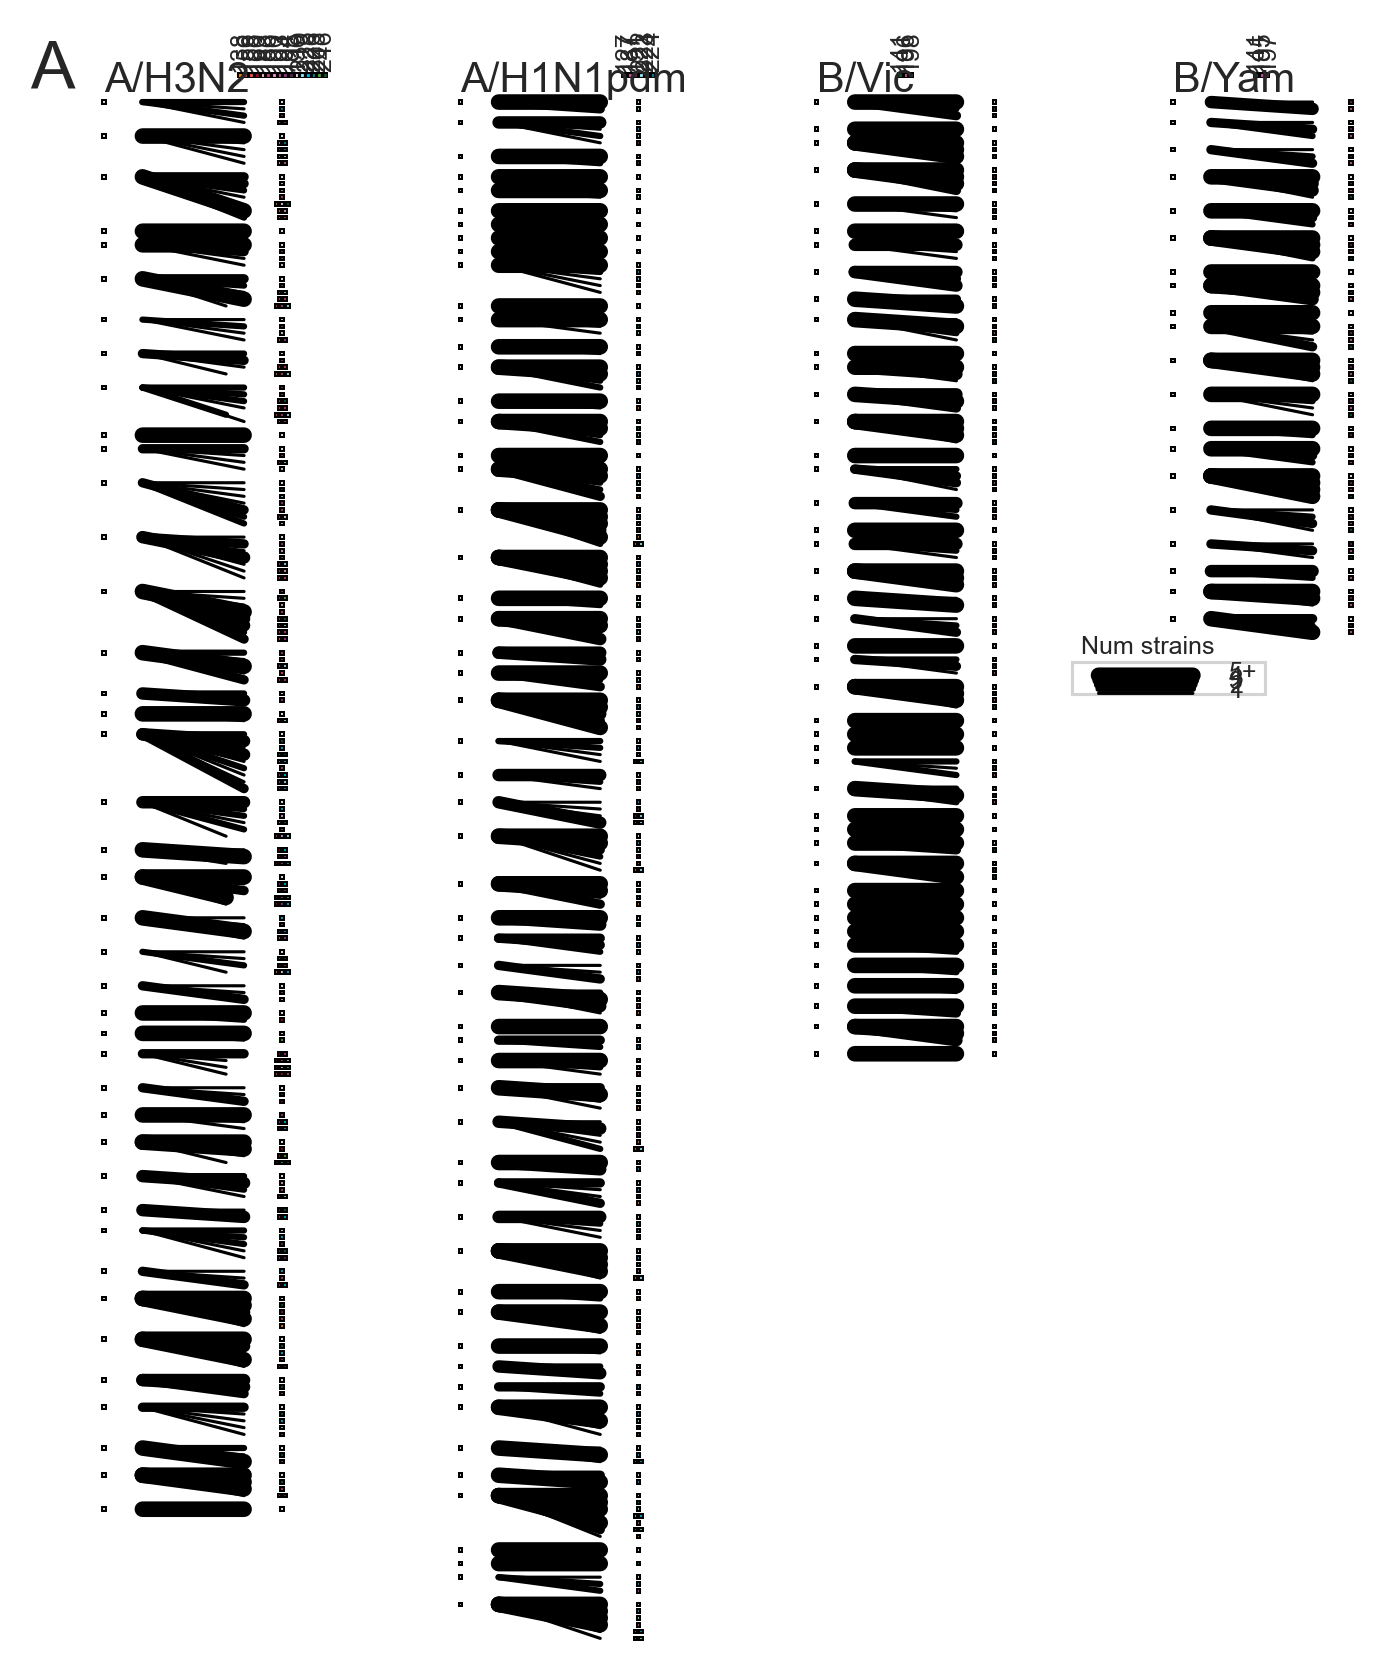

In [45]:
plot_figure7()

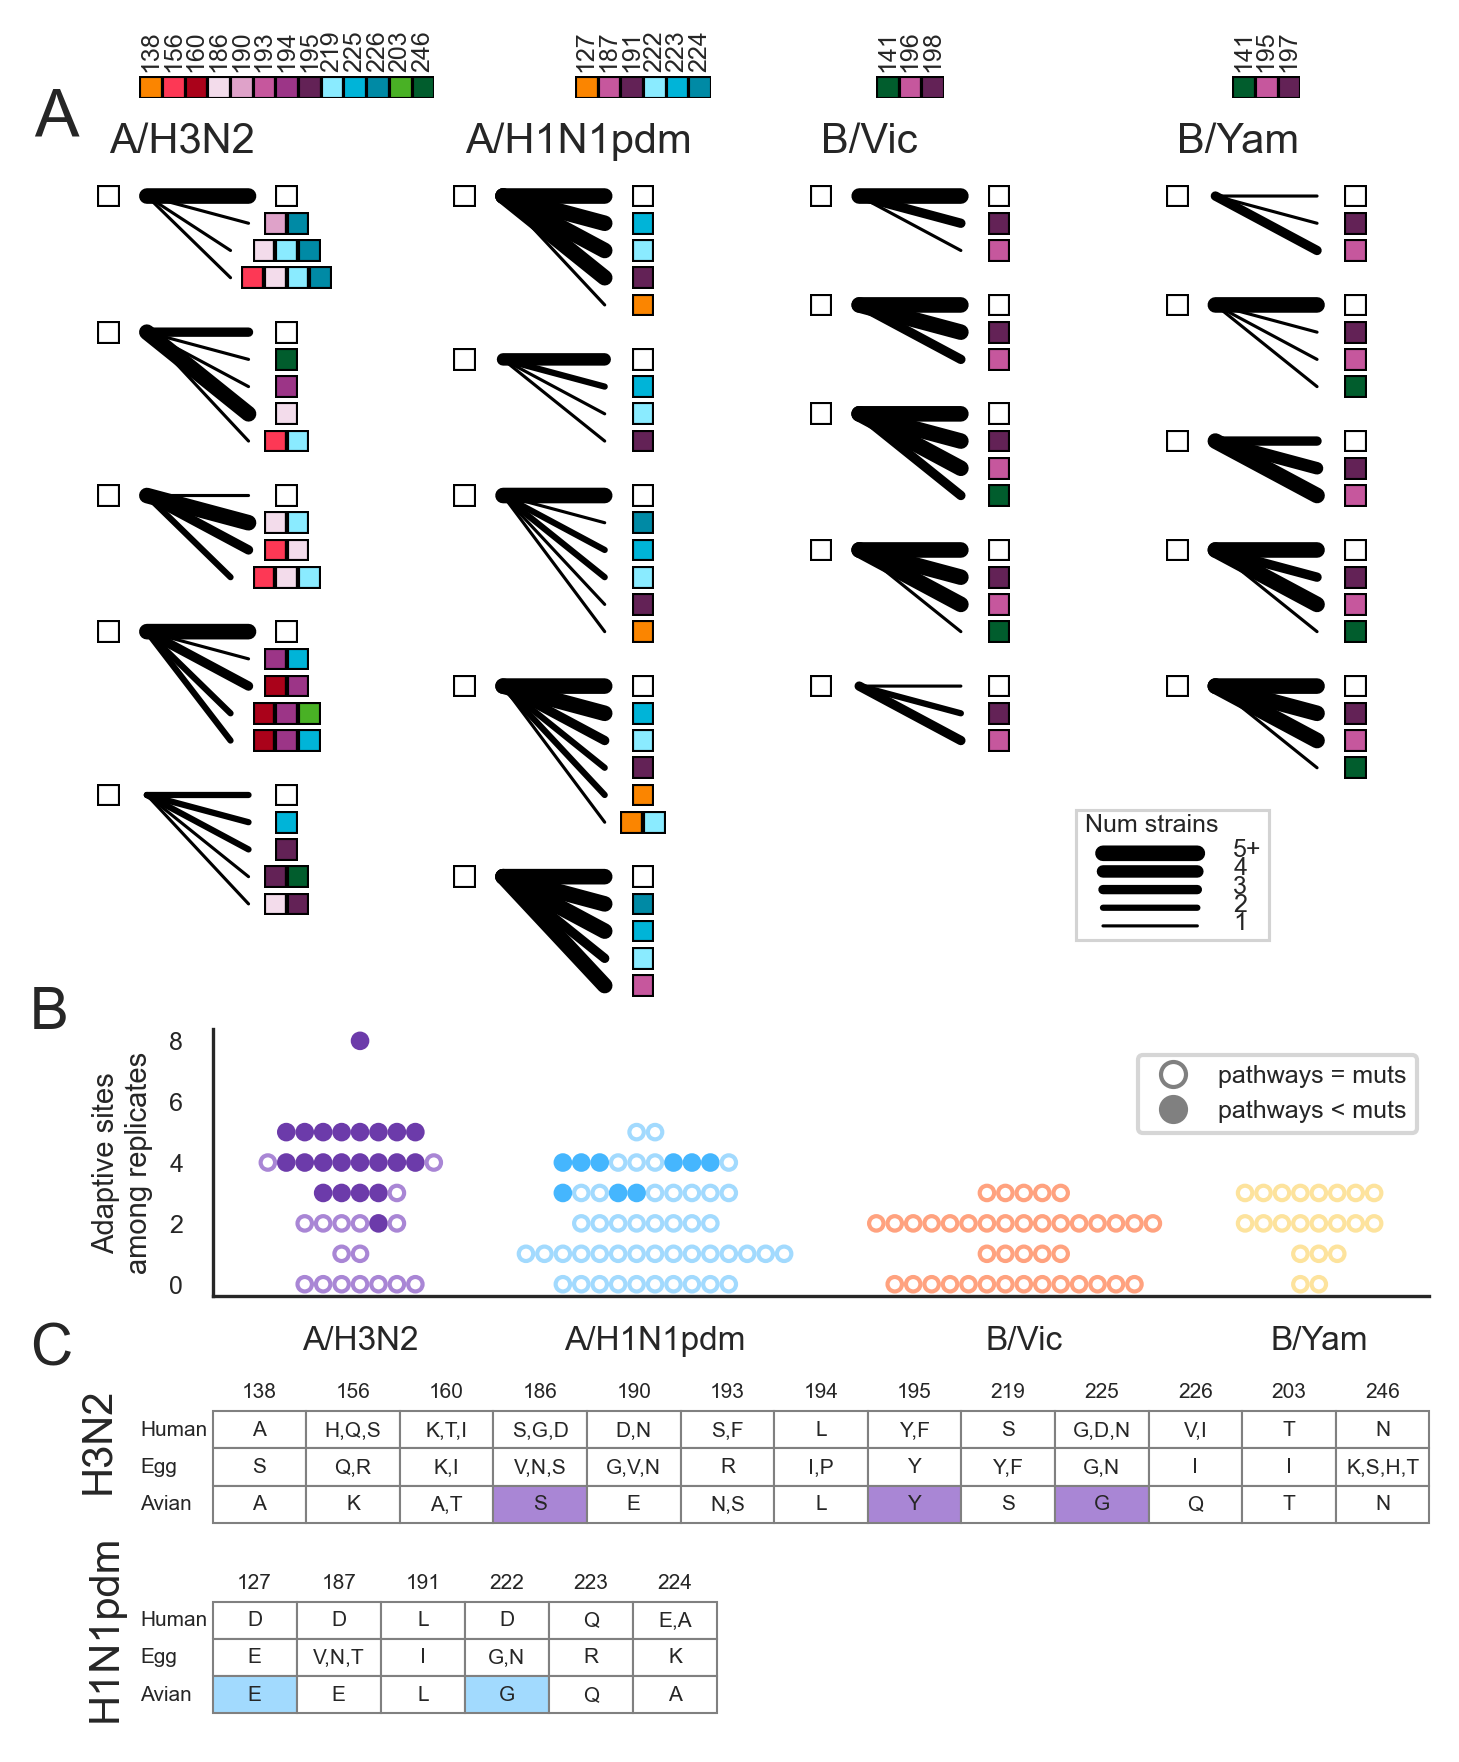

In [567]:
plot_figure7(filename='Figure7/Figure7.png')

In [597]:
test = calc_set_summary_data()

In [598]:
test.head()

,virus,total_reps,rep_bin,num_diff_muts,fraction_of_possible_muts,num_pathways,ratio_pathways_muts,color_mapper
0,h3n2,5,low,2,0.153846,2,1.000000,h3n2_1
1,h3n2,7,mid,3,0.230769,2,0.666667,h3n2_0
2,h3n2,11,mid,2,0.153846,2,1.000000,h3n2_1
3,h3n2,13,mid,5,0.384615,2,0.400000,h3n2_0
4,h3n2,5,low,1,0.076923,1,1.000000,h3n2_1


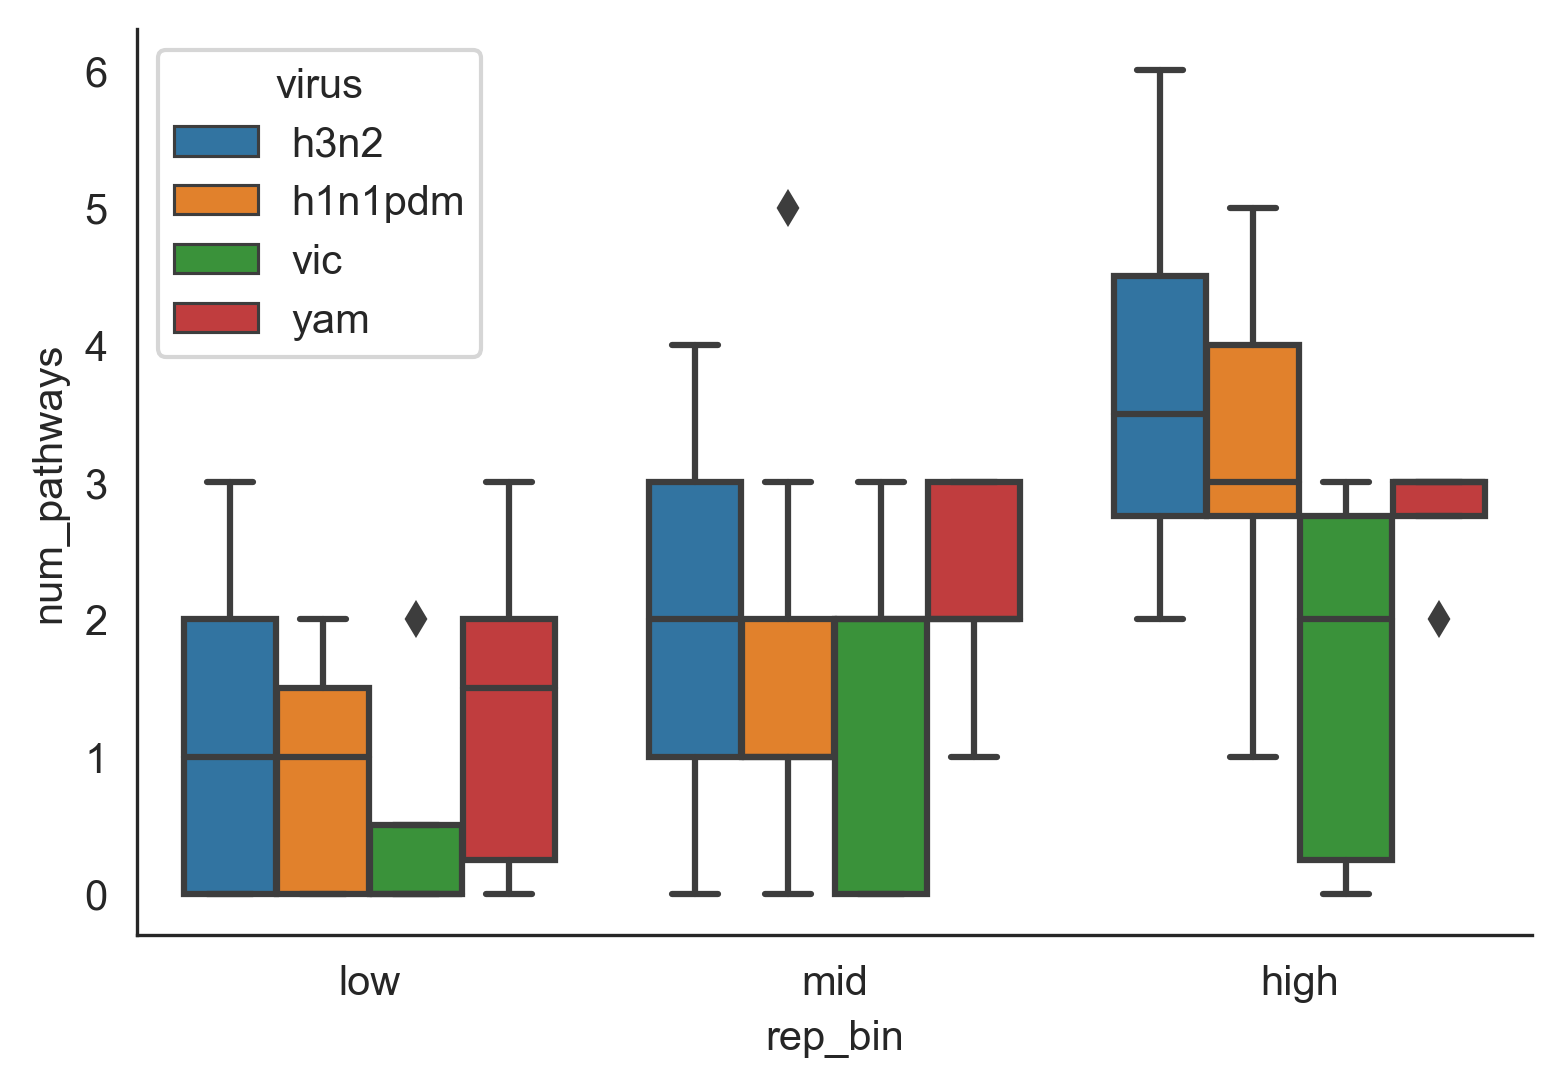

In [588]:
sns.boxplot(x='rep_bin', y='num_pathways', hue='virus', dodge=True, data=test)
sns.despine()

In [593]:
test.head()

,virus,total_reps,rep_bin,num_diff_muts,fraction_of_possible_muts,num_pathways,color_mapper
0,h3n2,5,low,2,0.153846,2,h3n2_1
1,h3n2,7,mid,3,0.230769,2,h3n2_0
2,h3n2,11,mid,2,0.153846,2,h3n2_1
3,h3n2,13,mid,5,0.384615,2,h3n2_0
4,h3n2,5,low,1,0.076923,1,h3n2_1


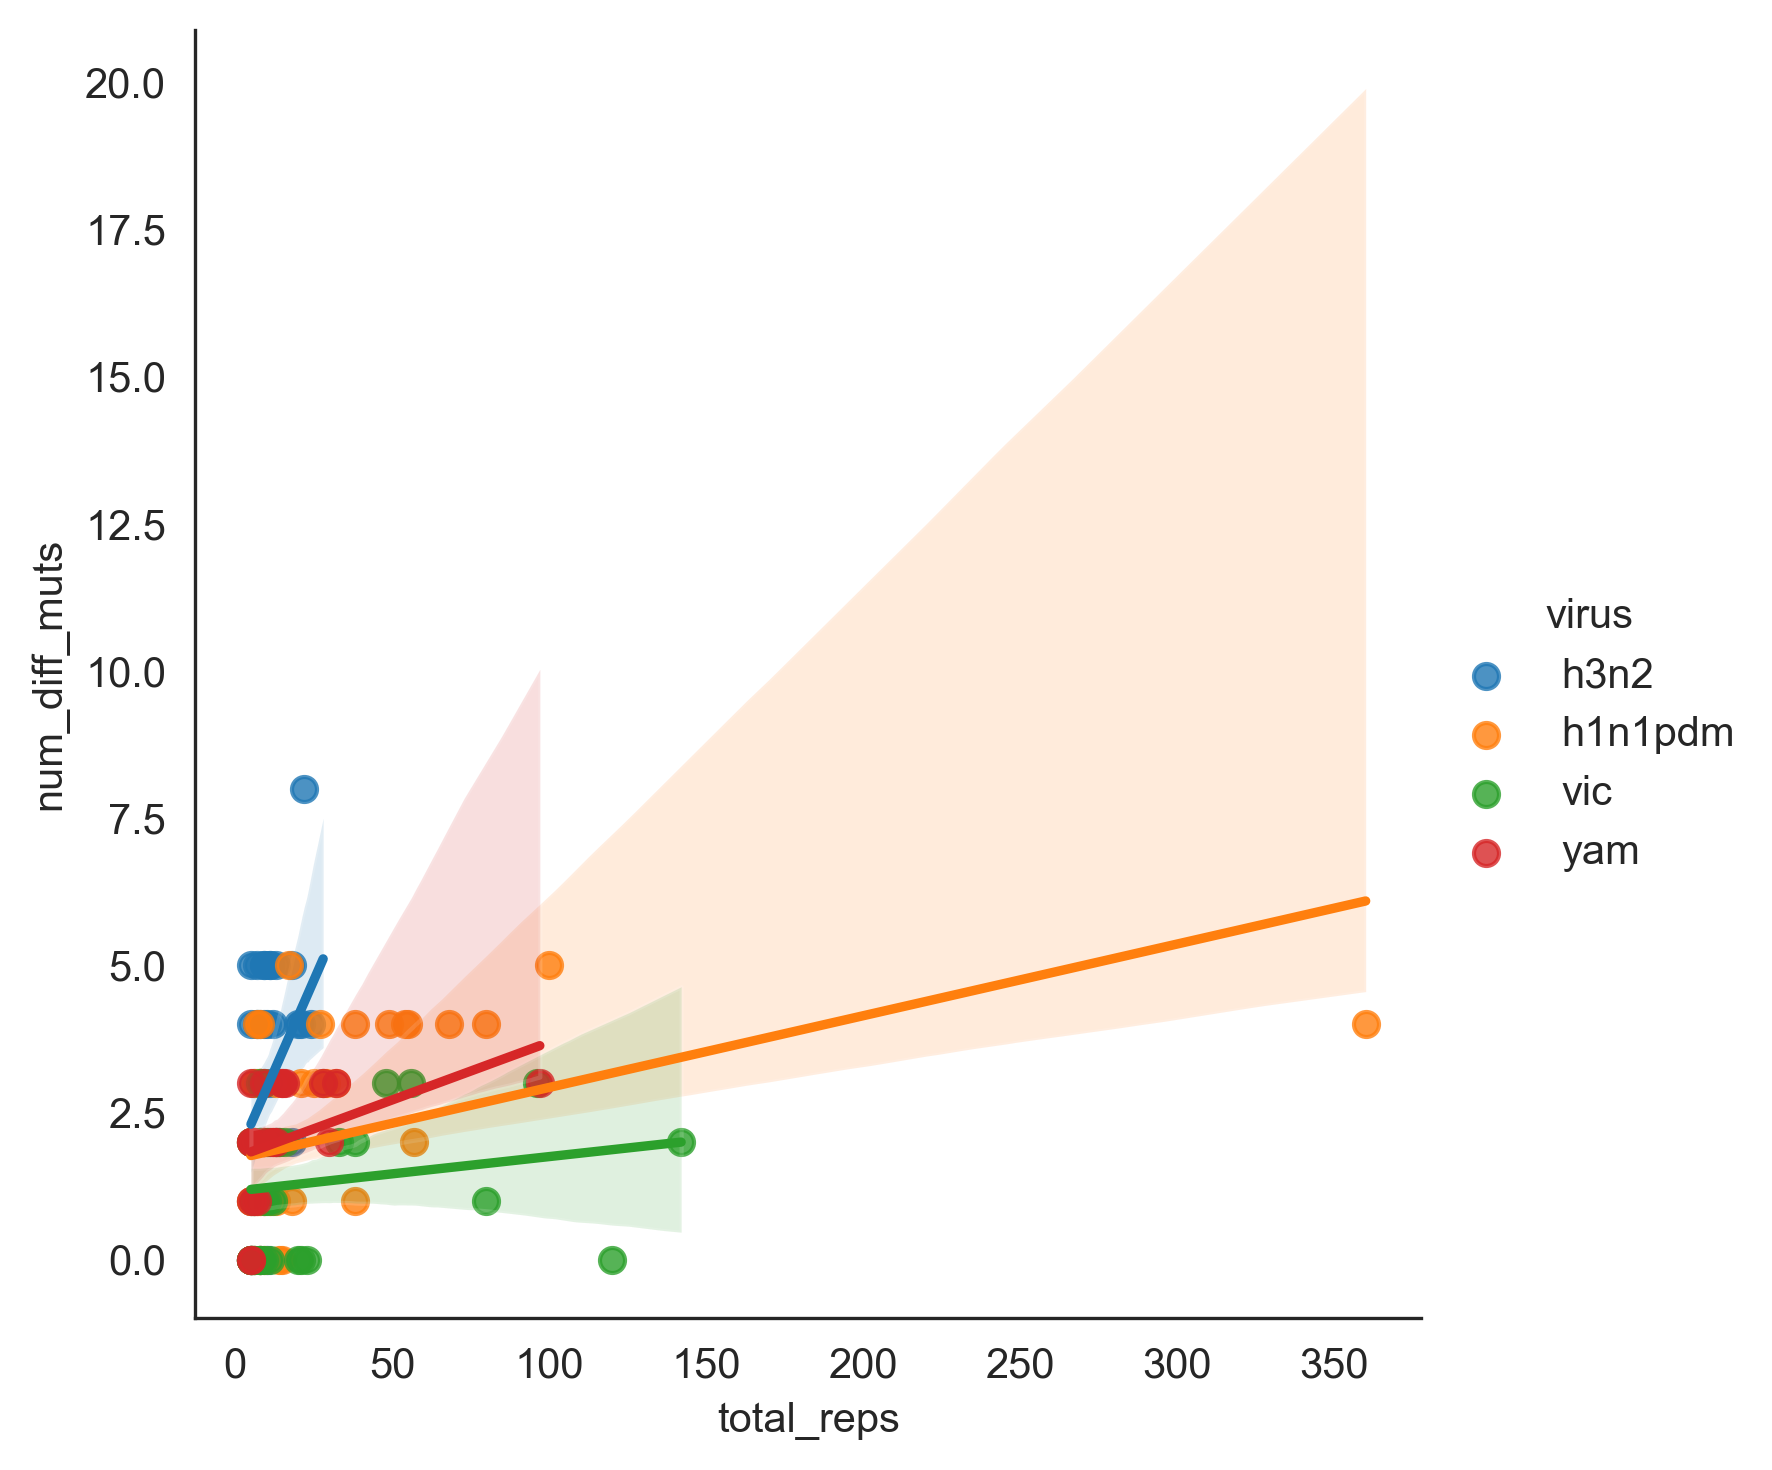

In [603]:
sns.lmplot(x='total_reps', y='num_diff_muts', hue='virus', data=test)
sns.despine()

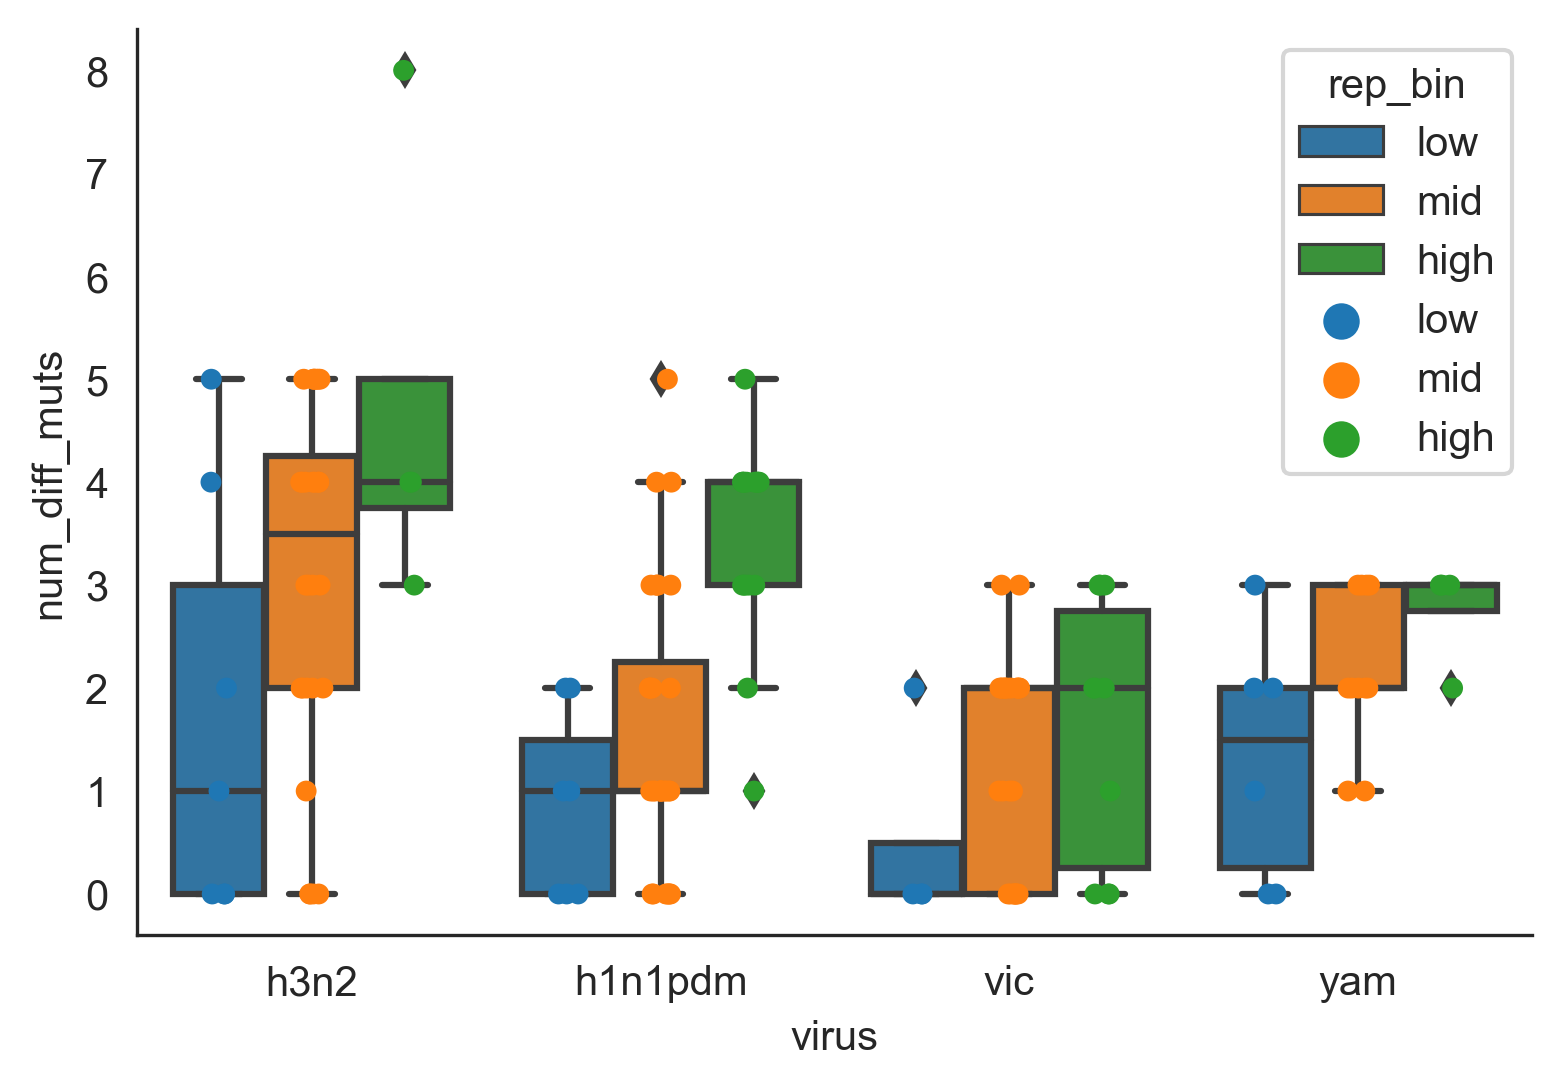

In [592]:
sns.boxplot(x='virus', y='num_diff_muts', hue='rep_bin', dodge=True, data=test)
sns.stripplot(x='virus', y='num_diff_muts', hue='rep_bin', dodge=True, data=test)

sns.despine()

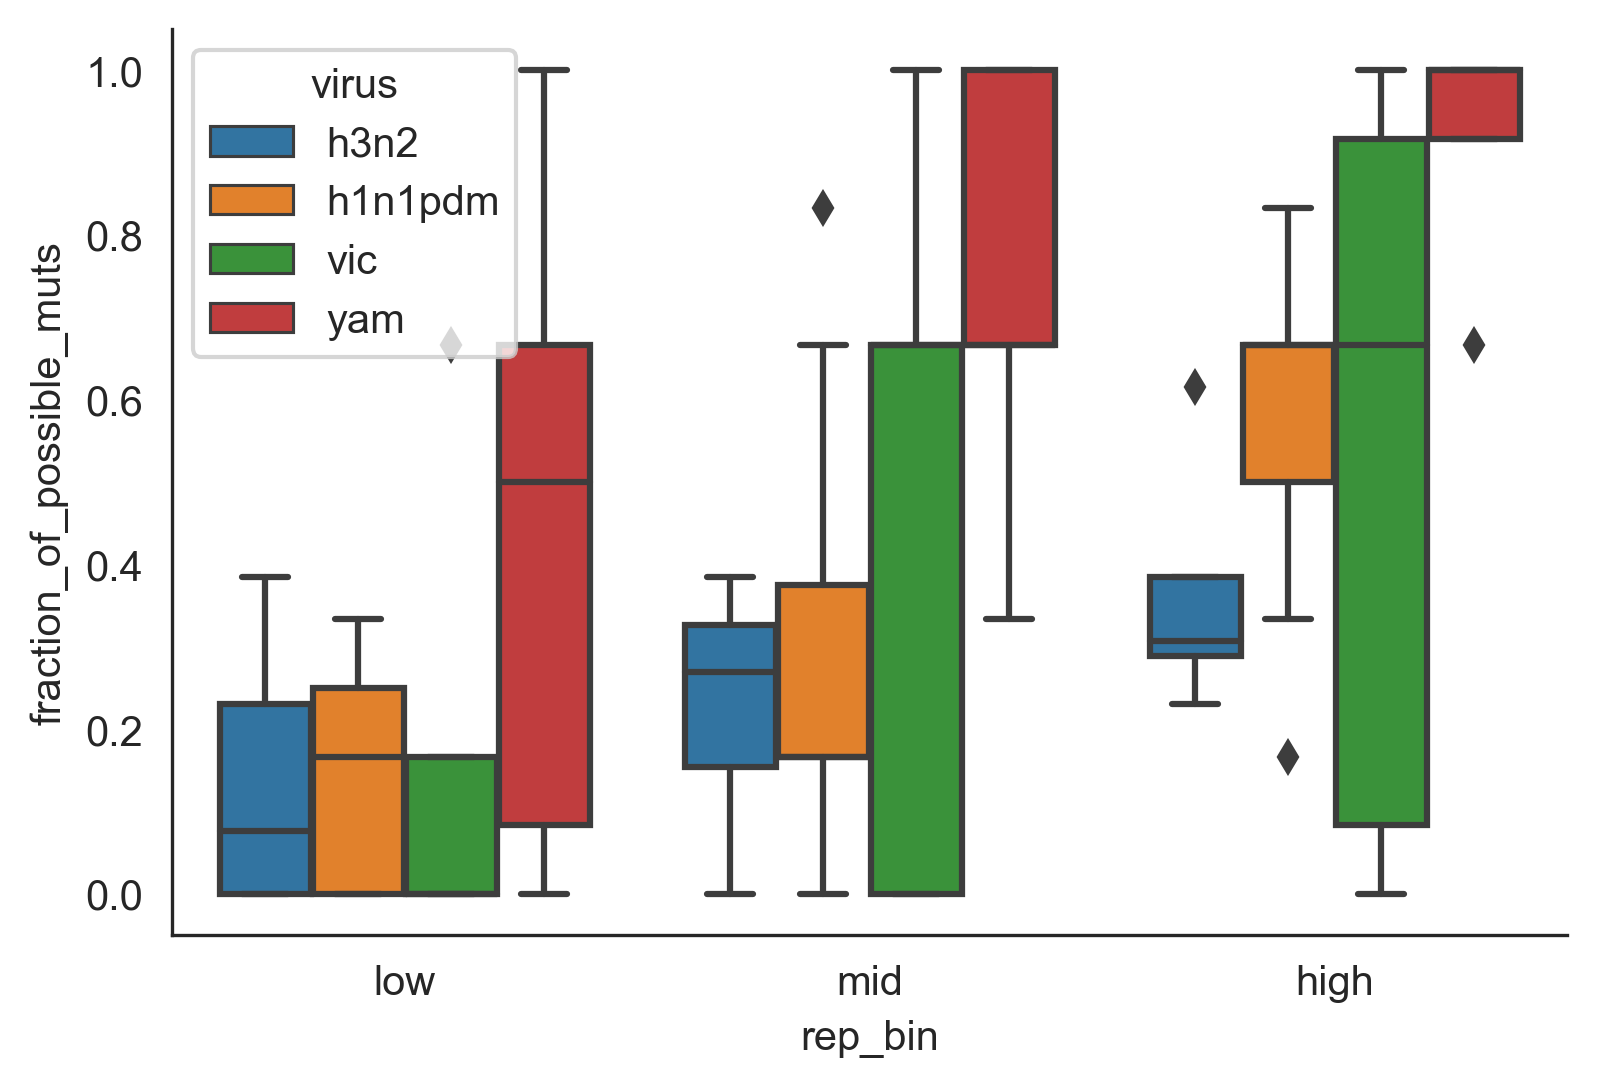

In [589]:
sns.boxplot(x='rep_bin', y='fraction_of_possible_muts', hue='virus', dodge=True, data=test)
sns.despine()